In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pycaret.classification import *
from sklearn.metrics import recall_score, precision_score, accuracy_score
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans ,AgglomerativeClustering
import seaborn as sns
import matplotlib as plt
from sklearn.metrics import confusion_matrix

In [49]:
pd.set_option('display.max_columns', None)

Getting main data:

In [3]:
df = pd.read_csv('data/rain_data_aus.csv')

Understanding Data:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date              142193 non-null  object 
 1   location          142193 non-null  object 
 2   mintemp           141556 non-null  float64
 3   maxtemp           141871 non-null  float64
 4   rainfall          140787 non-null  float64
 5   evaporation       81350 non-null   float64
 6   sunshine          74377 non-null   float64
 7   humidity9am       140419 non-null  float64
 8   humidity3pm       138583 non-null  float64
 9   pressure9am       128179 non-null  float64
 10  pressure3pm       128212 non-null  float64
 11  cloud9am          88536 non-null   float64
 12  cloud3pm          85099 non-null   float64
 13  temp9am           141289 non-null  float64
 14  temp3pm           139467 non-null  float64
 15  raintoday         140787 non-null  object 
 16  amountOfRain      14

In [5]:
df.replace(('Yes', 'No'), (1, 0), inplace=True)
df.corr()['raintomorrow'].sort_values(ascending=False)

raintomorrow        1.000000
modelo_vigente      0.825086
amountOfRain        0.501485
humidity3pm         0.446160
humidity            0.405600
cloud3pm            0.381870
cloud9am            0.317380
raintoday           0.313097
humidity9am         0.257161
rainfall            0.239032
mintemp             0.083936
precipitation3pm    0.004503
precipitation9am   -0.007018
temp9am            -0.025691
evaporation        -0.119285
temp               -0.125976
maxtemp            -0.159237
temp3pm            -0.192424
pressure3pm        -0.226031
pressure9am        -0.246371
sunshine           -0.450768
Name: raintomorrow, dtype: float64

Let's remove 'modelo_vigente' and 'amountOfRain' to avoid leakage

In [6]:
df.drop(columns = ['modelo_vigente','amountOfRain'], inplace=True)

As we can see, 'sunshine' has a strong correlation, but many nulls. We will solve this later.

Importing and cleaning the wind tables:

In [7]:
wind = pd.read_csv(f'data/wind_table_01.csv')

for i in range(2,8):
    wind_new = pd.read_csv(f'data/wind_table_0{i}.csv')
    if 'wind_gustdir' not in wind_new.columns:
        wind_new['wind_gustdir'] = wind_new['windgustdir']
        wind_new['wind_gustspeed'] = wind_new['windgustspeed']
        wind_new['wind_dir9am'] = wind_new['winddir9am']
        wind_new['wind_dir3pm'] = wind_new['winddir3pm']
        wind_new['wind_speed9am'] = wind_new['windspeed9am']
        wind_new['wind_speed3pm'] = wind_new['windspeed3pm']
        
    wind = wind.append(wind_new)
    
wind = wind.drop(['windgustdir','windgustspeed','winddir9am','winddir3pm','windspeed9am','windspeed3pm'], axis=1)

df = pd.merge(left = df, right = wind, how = 'outer', left_on = ['date','location'], right_on = ['date','location'])

Result:

In [8]:
df

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0,29.48,28.400000,12,5.115360,W,44.0,W,WNW,20.0,24.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0,32.12,2.208569,10,21.497100,WNW,44.0,NNW,WSW,4.0,22.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0,32.84,38.000000,17,20.782859,WSW,46.0,W,WSW,19.0,26.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0,35.60,21.200000,8,12.028646,NE,24.0,SE,E,11.0,9.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0,40.76,41.600000,9,11.883546,W,41.0,ENE,NW,7.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,0.0,0,28.16,34.400000,12,5.848681,E,31.0,ESE,E,15.0,13.0
142189,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,0.0,0,30.08,30.800000,10,6.653879,E,31.0,SE,ENE,13.0,11.0
142190,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,0.0,0,32.36,27.200000,9,19.715976,NNW,22.0,SE,N,13.0,9.0
142191,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,0.0,0,34.28,30.800000,12,0.985551,N,37.0,SE,WNW,9.0,9.0


Getting more usefull information from the table:

In [9]:
df['summer'] = pd.DatetimeIndex(df['date']).month.isin([12,1,2])
df['fall'] = pd.DatetimeIndex(df['date']).month.isin([3,4,5])
df['winter'] = pd.DatetimeIndex(df['date']).month.isin([6,7,8])
df['spring'] = pd.DatetimeIndex(df['date']).month.isin([9,10,11])

print(f"Summer: {df['raintomorrow'][df['summer']==True].mean()}")
print(f"Fall: {df['raintomorrow'][df['fall']==True].mean()}")
print(f"Winter: {df['raintomorrow'][df['winter']==True].mean()}")
print(f"Spring: {df['raintomorrow'][df['spring']==True].mean()}")

Summer: 0.20303012610929472
Fall: 0.21886782362221568
Winter: 0.2612023378792096
Spring: 0.2124241548685351


And from the distances, we can check useful distance features using its Coordinates (More info in the Coord Notebook):

In [10]:
df_coord = pd.read_csv('data/coord.csv')
df_coord.rename(columns = {'Unnamed: 0':'location'},inplace=True)
df_coord

,location,latitude,longitude,coastDistance
0,Albury,-36.080477,146.916280,129.486
1,BadgerysCreek,-33.881667,150.744163,17.422
2,Cobar,-31.498333,145.834444,342.042
3,CoffsHarbour,-30.296241,153.113529,1.448
4,Moree,-29.461720,149.840715,204.251
5,Newcastle,-32.919295,151.779535,0.849
6,NorahHead,-33.281667,151.567778,0.497
7,NorfolkIsland,-29.032804,167.948314,0.843
8,Penrith,-33.751195,150.694171,25.400
9,Richmond,-37.820395,145.002515,23.984


In australia, the proximity with the shore is a key information when we talk about rain. So, using the API from kbgeo and the coordinates we can get those distances. 

In [11]:
df = pd.merge(left = df, right = df_coord, how = 'outer', left_on = ['location'], right_on = ['location'])

Now, with a more robust dataset, let's check the data:

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 142192
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date              142193 non-null  object 
 1   location          142193 non-null  object 
 2   mintemp           141556 non-null  float64
 3   maxtemp           141871 non-null  float64
 4   rainfall          140787 non-null  float64
 5   evaporation       81350 non-null   float64
 6   sunshine          74377 non-null   float64
 7   humidity9am       140419 non-null  float64
 8   humidity3pm       138583 non-null  float64
 9   pressure9am       128179 non-null  float64
 10  pressure3pm       128212 non-null  float64
 11  cloud9am          88536 non-null   float64
 12  cloud3pm          85099 non-null   float64
 13  temp9am           141289 non-null  float64
 14  temp3pm           139467 non-null  float64
 15  raintoday         140787 non-null  float64
 16  raintomorrow      14

In [13]:
df.corr()[['raintomorrow']].sort_values('raintomorrow',ascending=False)

,raintomorrow
raintomorrow,1.000000
humidity3pm,0.446160
humidity,0.405600
cloud3pm,0.381870
cloud9am,0.317380
raintoday,0.313097
humidity9am,0.257161
rainfall,0.239032
wind_gustspeed,0.234010
wind_speed9am,0.090995


Looking deeper in the target column:

<AxesSubplot: xlabel='raintomorrow', ylabel='count'>

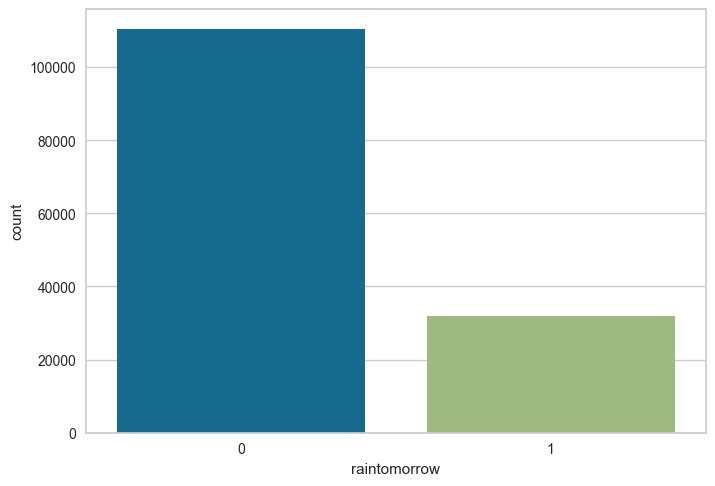

In [14]:
sns.countplot(x=df['raintomorrow'], data=df)

The amount of days without rain is far greater than the amount of rainy days. This information can be useful to build the model 

About the missing values, we can use pycaret imputation methods and see what happens...

In [15]:
data_train,data_test = train_test_split(df, test_size = 0.2)

In [20]:
classification = setup(data = data_train, target = 'raintomorrow', normalize = True, remove_multicollinearity = True,
                       ignore_low_variance=True, imputation_type='iterative', iterative_imputation_iters=2,remove_outliers=True)

,Description,Value
0,session_id,450
1,Target,raintomorrow
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(113754, 34)"
5,Missing Values,True
6,Numeric Features,21
7,Categorical Features,11
8,Ordinal Features,False
9,High Cardinality Features,False


In [23]:
best_model = compare_models(exclude=['knn'],fold = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8564,0.8834,0.5295,0.7541,0.6221,0.5368,0.5496,0.6300
rf,Random Forest Classifier,0.8516,0.8754,0.4648,0.7821,0.5831,0.4998,0.5249,3.2000
gbc,Gradient Boosting Classifier,0.8491,0.8686,0.4899,0.7473,0.5918,0.5042,0.5211,8.3700
et,Extra Trees Classifier,0.8471,0.8690,0.4382,0.7806,0.5613,0.4774,0.5066,4.9367
lr,Logistic Regression,0.8460,0.8669,0.5096,0.7186,0.5963,0.5045,0.5159,3.1000
ridge,Ridge Classifier,0.8453,0.0000,0.4681,0.7440,0.5746,0.4860,0.5055,0.1667
lda,Linear Discriminant Analysis,0.8448,0.8636,0.5278,0.7028,0.6029,0.5088,0.5169,1.3500
ada,Ada Boost Classifier,0.8426,0.8585,0.4863,0.7176,0.5797,0.4872,0.5012,2.1333
svm,SVM - Linear Kernel,0.8422,0.0000,0.4707,0.7308,0.5705,0.4796,0.4981,0.3967
dt,Decision Tree Classifier,0.7825,0.6903,0.5236,0.5126,0.5180,0.3776,0.3776,1.5133


lgbm is the best model for predicting. but still, even though we had good Accuracy, and AUC, the Recall score was not what we expected. Let's take a better look...

In [24]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8579,0.8783,0.5198,0.7688,0.6203,0.5369,0.5524
1,0.8582,0.8869,0.5394,0.7554,0.6294,0.5447,0.5565
2,0.8587,0.8811,0.5352,0.7609,0.6284,0.5444,0.5573
3,0.8595,0.8865,0.5465,0.7566,0.6346,0.5504,0.5615
4,0.8533,0.8810,0.5198,0.7460,0.6127,0.5257,0.5388
5,0.8614,0.8934,0.5385,0.7716,0.6343,0.5522,0.5658
6,0.8564,0.8837,0.5296,0.7538,0.6221,0.5368,0.5496
7,0.8574,0.8857,0.5441,0.7484,0.6301,0.5445,0.5551
8,0.8548,0.8842,0.5305,0.7460,0.6201,0.5335,0.5453


In [25]:
lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=450, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

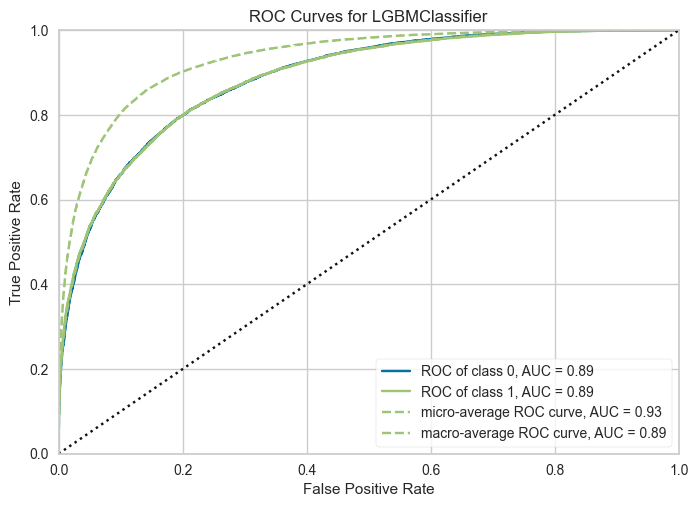

In [26]:
plot_model(lgbm, plot = 'auc')

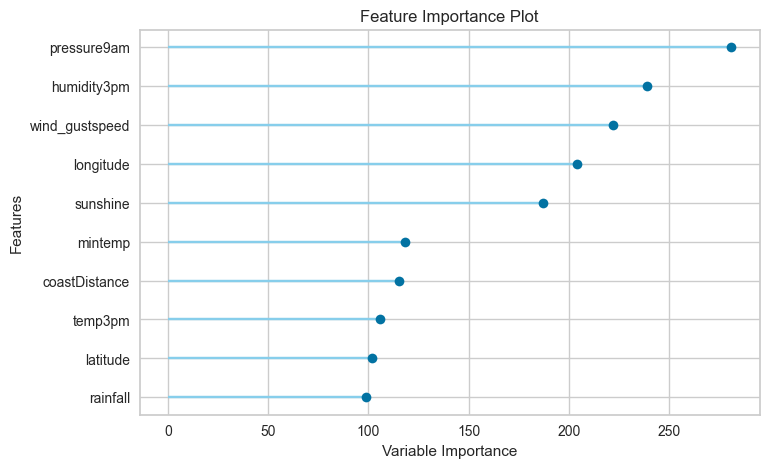

In [27]:
plot_model(lgbm, plot = 'feature')

The Pressure at 9am was the most important feature in the model. And the Coast distance was not as important as expected.

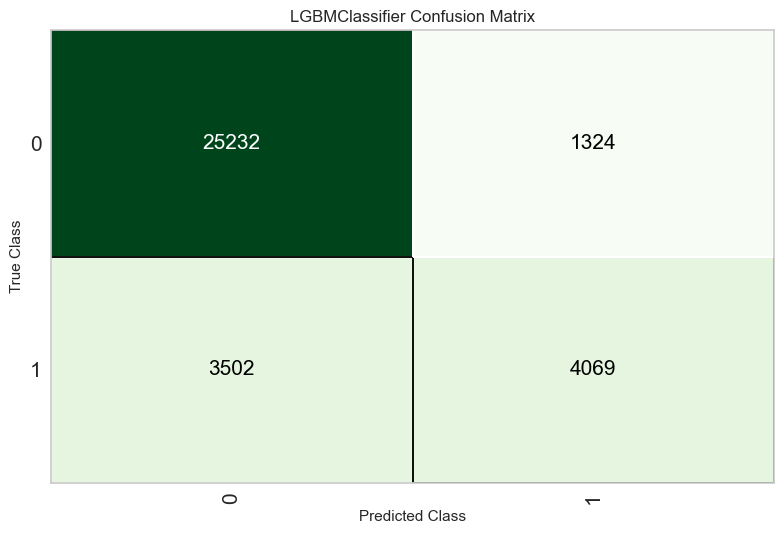

In [28]:
plot_model(lgbm, plot = 'confusion_matrix')

With the confusion matrix we can visualize why the recall score was so low: Once the 'raintomorrow' feature is unbalanced, the amount of predicted negatives will be far greater than the amount of predicted of positives. So, the model will get it wrong more times by saying it will not rain and it actually rains, than the oposite.

To maximize the recall score. We can create a new model, using the 'fix_imbalance' feature from pycaret.

In [16]:
classification = setup(data = data_train, target = 'raintomorrow', normalize = True, remove_multicollinearity = True,
                       ignore_low_variance=True, imputation_type='iterative', iterative_imputation_iters=2,remove_outliers=True, fix_imbalance= True)

,Description,Value
0,session_id,3494
1,Target,raintomorrow
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(113754, 34)"
5,Missing Values,True
6,Numeric Features,21
7,Categorical Features,11
8,Ordinal Features,False
9,High Cardinality Features,False


In [18]:
best_model = compare_models(exclude=['knn','gbc'],fold = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8530,0.8805,0.5491,0.7227,0.6240,0.5348,0.5426,14.2267
rf,Random Forest Classifier,0.8473,0.8721,0.5695,0.6890,0.6236,0.5288,0.5326,18.5467
et,Extra Trees Classifier,0.8456,0.8655,0.5168,0.7093,0.5979,0.5053,0.5150,21.9667
ada,Ada Boost Classifier,0.8040,0.8411,0.6456,0.5501,0.5940,0.4659,0.4685,16.7633
lr,Logistic Regression,0.7865,0.8655,0.7713,0.5129,0.6161,0.4765,0.4955,17.1100
lda,Linear Discriminant Analysis,0.7853,0.8651,0.7704,0.5110,0.6145,0.4740,0.4931,14.7567
ridge,Ridge Classifier,0.7852,0.0000,0.7703,0.5110,0.6144,0.4739,0.4931,13.1367
svm,SVM - Linear Kernel,0.7828,0.0000,0.7663,0.5085,0.6106,0.4687,0.4883,13.4400
dummy,Dummy Classifier,0.7779,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,13.0967
dt,Decision Tree Classifier,0.7735,0.6976,0.5609,0.4914,0.5238,0.3761,0.3775,15.1833


Very small improvement with the lgbm model, but depending on the finality of the analysis, we can choose a different model from this setup. 

For now, let's use this model to predict the testing data frame

In [19]:
lgbm_1 = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8489,0.8696,0.5423,0.7089,0.6145,0.5226,0.5299
1,0.8434,0.8714,0.5125,0.7017,0.5924,0.4983,0.5077
2,0.8522,0.8788,0.5536,0.7165,0.6246,0.5345,0.5413
3,0.8559,0.8887,0.5562,0.7310,0.6318,0.5442,0.5521
4,0.8526,0.8823,0.5521,0.7194,0.6247,0.5350,0.5422
5,0.8542,0.8827,0.5375,0.7347,0.6208,0.5332,0.5432
6,0.8558,0.8872,0.5696,0.7223,0.6369,0.5485,0.5545
7,0.8534,0.8775,0.5357,0.7323,0.6188,0.5307,0.5406
8,0.8601,0.8869,0.5780,0.7356,0.6473,0.5617,0.5680


In [22]:
predictions = predict_model(lgbm_1, data=data_test, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8500,0.8776,0.5462,0.7188,0.6207,0.5293,0.5371


In [23]:
predictions

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,...,summer,fall,winter,spring,latitude,longitude,coastDistance,Label,Score_0,Score_1
44725,2008-11-09,Canberra,6.4,23.0,0.0,5.4,13.1,67.0,28.0,1017.5,...,False,False,False,True,-35.297591,149.101268,64.111,0,0.9592,0.0408
35271,2015-12-03,SydneyAirport,16.9,23.4,0.2,9.2,8.1,55.0,47.0,1027.2,...,True,False,False,False,-33.935309,151.165582,0.363,0,0.9680,0.0320
60824,2012-01-24,Sale,12.9,31.3,0.0,8.0,13.1,75.0,47.0,1015.5,...,True,False,False,False,-38.105036,147.064790,18.761,0,0.9692,0.0308
50829,2009-02-01,MountGinini,18.0,25.0,0.0,NaN,NaN,22.0,36.0,NaN,...,True,False,False,False,-35.529744,148.772540,78.894,0,0.8494,0.1506
54789,2012-01-27,Ballarat,13.4,31.1,0.0,NaN,NaN,72.0,41.0,1015.8,...,True,False,False,False,-37.562303,143.860565,46.540,0,0.8611,0.1389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128097,2012-06-24,Hobart,5.2,11.7,8.8,2.2,6.5,43.0,44.0,1014.8,...,False,False,True,False,-42.882509,147.328123,0.532,0,0.7221,0.2779
102819,2017-01-17,Nuriootpa,13.2,39.9,0.0,11.6,13.5,28.0,5.0,1009.2,...,True,False,False,False,-34.469335,138.993901,32.370,0,0.9817,0.0183
115067,2010-01-05,PerthAirport,18.7,39.4,0.0,12.4,12.8,39.0,15.0,1008.1,...,True,False,False,False,-31.940610,115.967608,5.151,0,0.9778,0.0222
62593,2017-02-03,Sale,13.4,28.3,NaN,NaN,NaN,71.0,51.0,1016.2,...,True,False,False,False,-38.105036,147.064790,18.761,0,0.8641,0.1359


The model is complete!

Now, using this model and the data from December 14th 2022 (Yesterday). Let's predict if it will rain today!
(Data accessed using world weather on-line API https://www.worldweatheronline.com/)

In [ ]:
tuned_lgbm=tune_model(lgbm, optimize= 'Recall', n_iter = 4 )
pd.read_csv('data/rain_today.csv')

In [68]:
today = pd.read_csv('data/rain_today.csv')

Cleaning the new df:

In [69]:
today.columns

Index(['location', 'date', 'location.1', 'mintemp', 'maxtemp', 'rainfall',
       'evaporation', 'sunshine', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm',
       'raintoday', 'raintomorrow', 'temp', 'humidity', 'precipitation3pm',
       'precipitation9am', 'wind_gustdir', 'wind_gustspeed', 'wind_dir9am',
       'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm', 'cloud3pmtemp9am'],
      dtype='object')

In [70]:
today.drop(columns=['cloud3pmtemp9am','location.1'])

,location,date,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm
0,Albury,2022-12-14,6.0,15.0,0.0375,NaN,11.3,55.0,53.0,1013.0,1012.0,5.0,3.0,12.0,15.0,Yes,NaN,12.0,68.125,0.0,0.0,SW,20.875,WSW,SW,17.0,21.0
1,BadgerysCreek,2022-12-14,13.0,25.0,0.0000,NaN,14.5,34.0,16.0,1008.0,1006.0,3.0,1.0,20.0,25.0,No,NaN,21.0,37.625,0.0,0.0,WSW,18.125,WSW,SW,19.0,23.0
2,Cobar,2022-12-14,14.0,22.0,0.0000,NaN,11.6,36.0,18.0,1015.0,1011.0,0.0,0.0,16.0,22.0,No,NaN,18.0,32.125,0.0,0.0,S,32.625,S,SSW,28.0,28.0
3,CoffsHarbour,2022-12-14,17.0,25.0,0.0000,NaN,14.1,43.0,48.0,1007.0,1004.0,0.0,0.0,23.0,25.0,No,NaN,23.0,63.375,0.0,0.0,SSE,17.500,SSE,ESE,6.0,15.0
4,Moree,2022-12-14,18.0,28.0,0.0000,NaN,14.0,25.0,20.0,1010.0,1006.0,0.0,0.0,24.0,28.0,No,NaN,25.0,24.000,0.0,0.0,SSW,30.000,SW,SW,21.0,35.0
5,Newcastle,2022-12-14,15.0,26.0,0.0000,NaN,14.2,35.0,28.0,1007.0,1006.0,1.0,0.0,22.0,26.0,No,NaN,22.0,45.875,0.0,0.0,W,21.750,W,SSW,9.0,22.0
6,NorahHead,2022-12-14,14.0,25.0,0.0000,NaN,14.2,33.0,21.0,1007.0,1006.0,1.0,0.0,22.0,25.0,No,NaN,21.0,42.750,0.0,0.0,W,18.000,WSW,SW,13.0,18.0
7,NorfolkIsland,2022-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Penrith,2022-12-14,13.0,25.0,0.0000,NaN,14.5,34.0,16.0,1008.0,1006.0,3.0,1.0,20.0,25.0,No,NaN,21.0,37.625,0.0,0.0,WSW,18.125,WSW,SW,19.0,23.0
9,Richmond,2022-12-14,7.0,15.0,0.2875,NaN,9.3,85.0,54.0,1014.0,1015.0,8.0,6.0,10.0,15.0,Yes,NaN,12.0,71.500,0.3,0.4,SSW,27.500,SW,SSW,18.0,26.0


In [71]:
today.replace(('Yes', 'No'), (1, 0), inplace=True)
today['summer'] = pd.DatetimeIndex(today['date']).month.isin([12,1,2])
today['fall'] = pd.DatetimeIndex(today['date']).month.isin([3,4,5])
today['winter'] = pd.DatetimeIndex(today['date']).month.isin([6,7,8])
today['spring'] = pd.DatetimeIndex(today['date']).month.isin([9,10,11])
today = pd.merge(left = today, right = df_coord, how = 'outer', left_on = ['location'], right_on = ['location'])

In [72]:
predictions = predict_model(lgbm_1, data=today, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0,0,0,0,0,0,0


The prediction for December 15th:

In [73]:
pred = predictions[['location','Label','Score_0','Score_1']]
pred

,location,Label,Score_0,Score_1
0,Albury,0,0.6111,0.3889
1,BadgerysCreek,0,0.9784,0.0216
2,Cobar,0,0.9832,0.0168
3,CoffsHarbour,0,0.9824,0.0176
4,Moree,0,0.9945,0.0055
5,Newcastle,0,0.9851,0.0149
6,NorahHead,0,0.9922,0.0078
7,NorfolkIsland,0,0.5665,0.4335
8,Penrith,0,0.9789,0.0211
9,Richmond,0,0.5623,0.4377


The reality of december 15th:

In [63]:
df_check = pd.read_csv('data/rain_15_12')

In [75]:
df_check.replace(('Yes', 'No'), (1, 0), inplace=True)

In [76]:
check = pd.merge(left = pred, right = df_check, how = 'outer', left_on = ['location'], right_on = ['location'])

In [102]:
check.drop(columns=['location.1'])

,location,Label,Score_0,Score_1,date,rainfall,raintoday
0,Albury,0,0.6111,0.3889,2022-12-15,0.0000,0
1,BadgerysCreek,0,0.9784,0.0216,2022-12-15,0.0000,0
2,Cobar,0,0.9832,0.0168,2022-12-15,0.0000,0
3,CoffsHarbour,0,0.9824,0.0176,2022-12-15,0.0500,1
4,Moree,0,0.9945,0.0055,2022-12-15,0.0000,0
5,Newcastle,0,0.9851,0.0149,2022-12-15,0.0125,1
6,NorahHead,0,0.9922,0.0078,2022-12-15,0.0000,0
7,NorfolkIsland,0,0.5665,0.4335,2022-12-15,NaN,1
8,Penrith,0,0.9789,0.0211,2022-12-15,0.0000,0
9,Richmond,0,0.5623,0.4377,2022-12-15,0.0375,1


<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

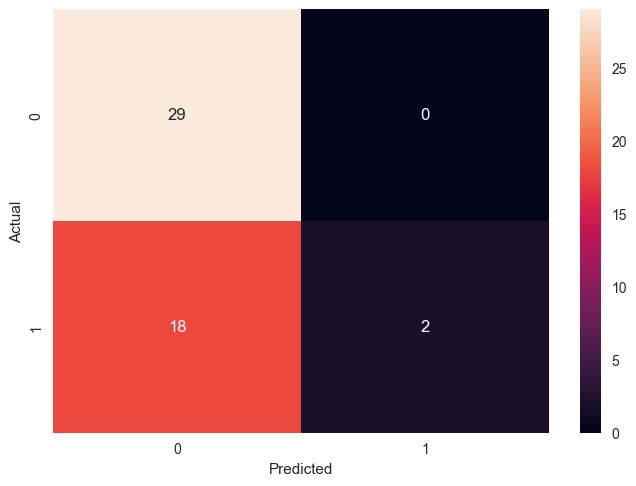

In [100]:
conf = {'actual': check['raintoday'], 'pred':check['Label']}
df_conf = pd.DataFrame(conf)
confusion_matrix = pd.crosstab(df_conf['actual'], df_conf['pred'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

Lots of False negatives. That's the problem with the low recall score, but even with the model's poor performance, this is only one day of prediction and we need more real data to evaluate deeply the model.